In [30]:
# Imports and libraries

import os
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from pathlib import Path


In [31]:
# Configuration

SAMPLE_RATE = 22050
DURATION = 5  # seconds
N_MELS = 128
N_FFT = 2048
HOP_LENGTH = 512
MAX_PAD_LEN = int(np.ceil((SAMPLE_RATE * DURATION) / HOP_LENGTH))

BASE_DIR = Path.cwd() if 'notebooks' not in str(Path.cwd()) else Path.cwd().parent
DATA_DIR = BASE_DIR / 'data'
AUDIO_DIR = DATA_DIR / 'processed' / 'birdcall_segments_5s' / 'birdcall_segments_5s'
RANDOM_STATE = 42


In [32]:
# Convert audio files to mel spectrograms

def load_and_preprocess_audio(file_path):
    y, sr = librosa.load(file_path, sr=SAMPLE_RATE, duration=DURATION)
    
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=N_MELS, n_fft=N_FFT, hop_length=HOP_LENGTH)
    S_dB = librosa.power_to_db(S, ref=np.max)
    S_dB = (S_dB - np.min(S_dB)) / (np.max(S_dB) - np.min(S_dB))
    S_dB = np.pad(S_dB, ((0, 0), (0, max(0, MAX_PAD_LEN - S_dB.shape[1]))), mode='constant')
    S_dB = S_dB[:, :MAX_PAD_LEN]
    return S_dB[..., np.newaxis]


In [33]:
# Encode labels

def create_dataset():
    wav_files = list(Path(AUDIO_DIR).glob("*.wav"))
    labels = [f.stem.split('_')[0] for f in wav_files]

    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(labels)

    X = []
    y_clean = []

    for f, label in zip(wav_files, y):
        spec = load_and_preprocess_audio(f)
        if spec is not None:
            X.append(spec)
            y_clean.append(label)

    X = np.array(X)
    y_clean = np.array(y_clean)

    return X, y_clean, label_encoder


In [34]:
# CNN model architecture

def create_cnn(input_shape, num_classes):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.GlobalAveragePooling2D(),
        
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model


In [35]:
# Train the model

def train_cnn_model():
    X, y, label_encoder = create_dataset()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
    
    input_shape = X_train[0].shape
    num_classes = len(np.unique(y))

    model = create_cnn(input_shape, num_classes)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = model.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size=16, callbacks=[early_stopping])

    return model, history, label_encoder, X_test, y_test


In [36]:
# Evaluation

def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Blues')
    plt.ylabel('True')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()


In [37]:
# Main code

model, history, label_encoder, X_test, y_test = train_cnn_model()
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.2f}")

y_pred = np.argmax(model.predict(X_test), axis=1)
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))
plot_confusion_matrix(y_test, y_pred, label_encoder.classes_)


Epoch 1/50
100/100 [==============================] - 66s 650ms/step - loss: 3.9321 - accuracy: 0.0394 - val_loss: 4.8177 - val_accuracy: 0.0300
Epoch 2/50
100/100 [==============================] - 64s 645ms/step - loss: 3.6043 - accuracy: 0.0637 - val_loss: 7.6153 - val_accuracy: 0.0175
Epoch 3/50
100/100 [==============================] - 63s 634ms/step - loss: 3.4682 - accuracy: 0.0756 - val_loss: 4.4511 - val_accuracy: 0.0650
Epoch 4/50
100/100 [==============================] - 66s 663ms/step - loss: 3.4145 - accuracy: 0.0869 - val_loss: 3.4972 - val_accuracy: 0.0500
Epoch 5/50
100/100 [==============================] - 66s 658ms/step - loss: 3.3292 - accuracy: 0.0900 - val_loss: 3.4211 - val_accuracy: 0.0825
Epoch 6/50
100/100 [==============================] - 66s 662ms/step - loss: 3.2764 - accuracy: 0.1050 - val_loss: 5.0070 - val_accuracy: 0.0575
Epoch 7/50
100/100 [==============================] - 68s 684ms/step - loss: 3.2403 - accuracy: 0.1187 - val_loss: 3.7881 - val_ac

KeyboardInterrupt: 

Epoch 1/50
88/88 [==============================] - 2s 5ms/step - loss: 4.5908 - accuracy: 0.0157 - val_loss: 3.9275 - val_accuracy: 0.0143
Epoch 2/50
88/88 [==============================] - 0s 3ms/step - loss: 4.4948 - accuracy: 0.0236 - val_loss: 3.9178 - val_accuracy: 0.0143
Epoch 3/50
88/88 [==============================] - 0s 4ms/step - loss: 4.4514 - accuracy: 0.0300 - val_loss: 3.8457 - val_accuracy: 0.0429
Epoch 4/50
88/88 [==============================] - 0s 3ms/step - loss: 4.2853 - accuracy: 0.0307 - val_loss: 3.7521 - val_accuracy: 0.0971
Epoch 5/50
88/88 [==============================] - 0s 3ms/step - loss: 4.2013 - accuracy: 0.0364 - val_loss: 3.6712 - val_accuracy: 0.1143
Epoch 6/50
88/88 [==============================] - 0s 3ms/step - loss: 4.1691 - accuracy: 0.0507 - val_loss: 3.6130 - val_accuracy: 0.1429
Epoch 7/50
88/88 [==============================] - 0s 3ms/step - loss: 4.0296 - accuracy: 0.0500 - val_loss: 3.5520 - val_accuracy: 0.1600
Epoch 8/50
88/88 [==

c:\UPF\Taller de Tecnologia Musical\Birdify\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\UPF\Taller de Tecnologia Musical\Birdify\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\UPF\Taller de Tecnologia Musical\Birdify\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

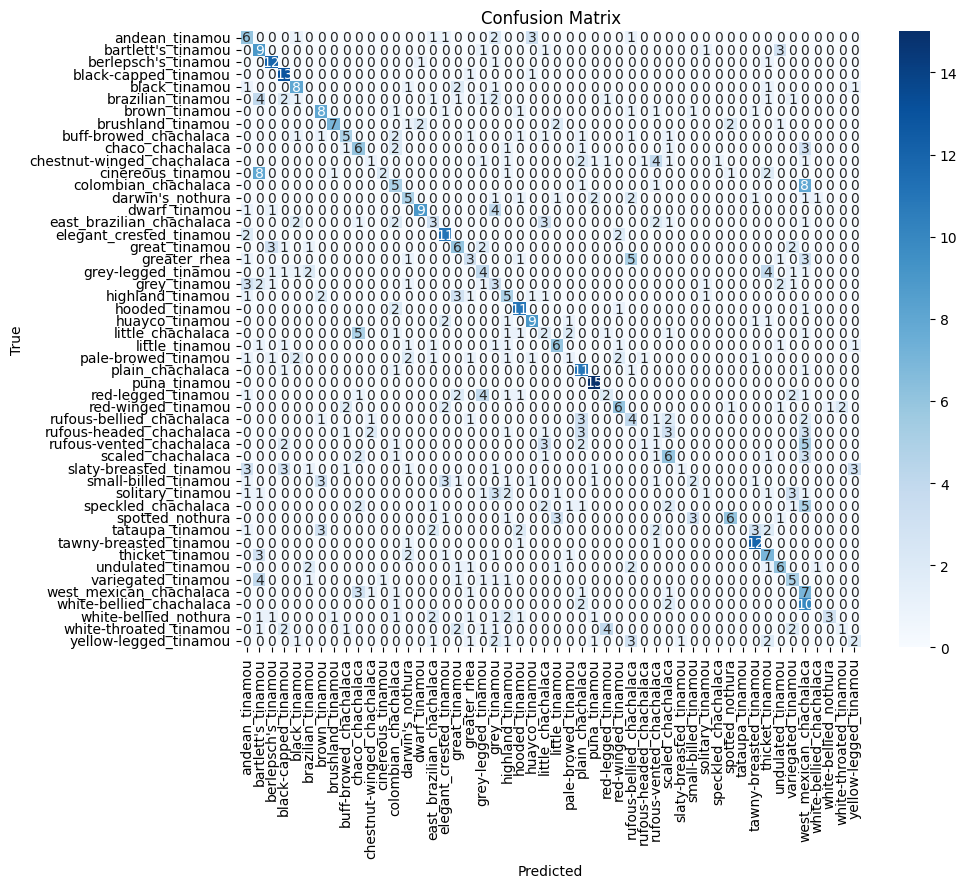

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

FEATURES_CSV = r"C:\UPF\Taller de Tecnologia Musical\Birdify\data\features\birdcall_features_song.csv"

def create_feature_dataset():
    df = pd.read_csv(FEATURES_CSV)
    X = df.select_dtypes(include=[np.number]).values
    y = df['species'].values

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    return X_scaled, y_encoded, label_encoder

def create_dense_model(input_shape, num_classes):
    model = models.Sequential([
        layers.Input(shape=(input_shape,)),
        layers.Dense(512, activation='relu'),           
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),          
        layers.BatchNormalization(),
        layers.Dropout(0.4),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(64, activation='relu'),        
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

def train_dense_model():
    X, y, label_encoder = create_feature_dataset()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
    num_classes = len(np.unique(y))

    model = create_dense_model(X_train.shape[1], num_classes)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = model.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size=16, callbacks=[early_stopping])

    return model, history, label_encoder, X_test, y_test


model, history, label_encoder, X_test, y_test = train_dense_model()
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.2f}")

y_pred = np.argmax(model.predict(X_test), axis=1)
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))
plot_confusion_matrix(y_test, y_pred, label_encoder.classes_)


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
import seaborn as sns
from pathlib import Path
import pandas as pd
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras_tuner.tuners import RandomSearch

# Constants (expanded from original)
SAMPLE_RATE = 22050
DURATION = 5  # seconds
N_MELS = 128
N_FFT = 2048
HOP_LENGTH = 512
MAX_PAD_LEN = int(np.ceil((SAMPLE_RATE * DURATION) / HOP_LENGTH))
AUDIO_DIR = r"C:\UPF\Taller de Tecnologia Musical\Birdify\data\processed\birdcall_segments_5s\birdcall_segments_5s"
FEATURES_CSV = r"C:\UPF\Taller de Tecnologia Musical\Birdify\data\features\birdcall_features_song.csv"  # Update with your CSV path

def load_and_preprocess_audio(file_path):
    """Enhanced audio preprocessing with optional augmentation"""
    try:
        y, sr = librosa.load(file_path, sr=SAMPLE_RATE, duration=DURATION)
        
        # Add optional time stretching and pitch shifting for augmentation
        if np.random.rand() > 0.5:  # 50% chance to augment
            y = librosa.effects.time_stretch(y, rate=np.random.uniform(0.9, 1.1))
            y = librosa.effects.pitch_shift(y, sr=sr, n_steps=np.random.uniform(-1, 1))
        
        S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=N_MELS, n_fft=N_FFT, hop_length=HOP_LENGTH)
        S_dB = librosa.power_to_db(S, ref=np.max)
        S_dB = (S_dB - np.min(S_dB)) / (np.max(S_dB) - np.min(S_dB))  # Min-max normalization
        S_dB = np.pad(S_dB, ((0, 0), (0, max(0, MAX_PAD_LEN - S_dB.shape[1]))), mode='constant')
        S_dB = S_dB[:, :MAX_PAD_LEN]
        return S_dB[..., np.newaxis]  # Add channel dimension
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

def load_features_and_labels():
    """Load both audio features and CSV features"""
    # Load audio features
    wav_files = list(Path(AUDIO_DIR).glob("*.wav"))
    labels = [f.stem.split('_')[0] for f in wav_files]
    
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(labels)
    
    X_audio = []
    y_clean = []
    file_ids = []
    
    for f, label in zip(wav_files, y):
        spec = load_and_preprocess_audio(f)
        if spec is not None:
            X_audio.append(spec)
            y_clean.append(label)
            file_ids.append(f.stem)  # Assuming filename can link to CSV
    
    X_audio = np.array(X_audio)
    y_clean = np.array(y_clean)
    
    # Load CSV features
    try:
        df_features = pd.read_csv(FEATURES_CSV)
        # Assuming CSV has 'file_id' column matching wav filenames
        df_features = df_features[df_features['filename'].str.replace('.wav', '').
                          isin(file_ids)]
        
        # Separate features and scale them
        feature_cols = [col for col in df_features.columns if col not in ['file_id', 'label']]
        X_csv = df_features[feature_cols].values
        X_csv = StandardScaler().fit_transform(X_csv)
        
        return X_audio, X_csv, y_clean, label_encoder, feature_cols
    except Exception as e:
        print(f"Error loading CSV features: {e}")
        return X_audio, None, y_clean, label_encoder, None

def build_hybrid_model(hp, input_audio_shape, num_classes, num_features=None):
    """Build a tunable hybrid CNN model that can use both audio and feature data"""
    # Audio branch
    audio_input = layers.Input(shape=input_audio_shape, name='audio_input')
    
    # Tunable CNN architecture
    x = audio_input
    for i in range(hp.Int('num_conv_blocks', 2, 4)):
        filters = hp.Choice(f'filters_{i}', [32, 64, 128])
        kernel_size = hp.Choice(f'kernel_size_{i}', [3, 5])
        
        x = layers.Conv2D(filters, (kernel_size, kernel_size), 
                         activation='relu', 
                         padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Conv2D(filters, (kernel_size, kernel_size), 
                         activation='relu', 
                         padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling2D((2, 2))(x)
        x = layers.Dropout(hp.Float(f'dropout_{i}', 0.1, 0.4))(x)
    
    x = layers.GlobalAveragePooling2D()(x)
    
    # Feature branch (if features available)
    if num_features:
        feature_input = layers.Input(shape=(num_features,), name='feature_input')
        y = layers.Dense(hp.Int('feature_dense_units', 32, 128), 
                        activation='relu',
                        kernel_regularizer=regularizers.l2(0.001))(feature_input)
        y = layers.BatchNormalization()(y)
        y = layers.Dropout(hp.Float('feature_dropout', 0.1, 0.5))(y)
        
        # Concatenate branches
        combined = layers.concatenate([x, y])
        inputs = [audio_input, feature_input]
    else:
        combined = x
        inputs = audio_input
    
    # Classifier head
    z = layers.Dense(hp.Int('dense_units', 128, 512), 
                    activation='relu',
                    kernel_regularizer=regularizers.l2(0.001))(combined)
    z = layers.BatchNormalization()(z)
    z = layers.Dropout(hp.Float('final_dropout', 0.3, 0.6))(z)
    
    output = layers.Dense(num_classes, activation='softmax')(z)
    
    model = models.Model(inputs=inputs, outputs=output)
    
    # Tunable learning rate
    lr = hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])
    
    return model

def train_model_with_tuning():
    """Train model with hyperparameter tuning"""
    X_audio, X_csv, y, label_encoder, feature_cols = load_features_and_labels()
    
    # Split data
    if X_csv is not None:
        X_train_audio, X_test_audio, X_train_csv, X_test_csv, y_train, y_test = train_test_split(
            X_audio, X_csv, y, test_size=0.2, stratify=y, random_state=42)
    else:
        X_train_audio, X_test_audio, y_train, y_test = train_test_split(
            X_audio, y, test_size=0.2, stratify=y, random_state=42)
        X_train_csv, X_test_csv = None, None
    
    input_audio_shape = X_train_audio[0].shape
    num_classes = len(np.unique(y))
    num_features = len(feature_cols) if feature_cols else None
    
    # Hyperparameter tuning
    tuner = RandomSearch(
        lambda hp: build_hybrid_model(hp, input_audio_shape, num_classes, num_features),
        objective='val_accuracy',
        max_trials=10,
        executions_per_trial=1,
        directory='tuning',
        project_name='bird_sound_classification')
    
    # Prepare input data for tuning
    train_inputs = {'audio_input': X_train_audio}
    val_inputs = {'audio_input': X_test_audio}
    
    if X_csv is not None:
        train_inputs['feature_input'] = X_train_csv
        val_inputs['feature_input'] = X_test_csv
    
    tuner.search(train_inputs, y_train,
                 validation_data=(val_inputs, y_test),
                 epochs=30,
                 batch_size=32,
                 callbacks=[EarlyStopping(patience=3)])
    
    # Get best model
    best_model = tuner.get_best_models(num_models=1)[0]
    
    # Train with more epochs on best configuration
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
    
    history = best_model.fit(train_inputs, y_train,
                            validation_data=(val_inputs, y_test),
                            epochs=100,
                            batch_size=32,
                            callbacks=[EarlyStopping(patience=5), reduce_lr])
    
    return best_model, history, label_encoder, (X_test_audio, X_test_csv), y_test

def evaluate_model(model, label_encoder, X_test, y_test):
    """Evaluate model performance"""
    test_inputs = {'audio_input': X_test[0]}
    if len(X_test) > 1 and X_test[1] is not None:
        test_inputs['feature_input'] = X_test[1]
    
    test_loss, test_acc = model.evaluate(test_inputs, y_test)
    print(f"Test Accuracy: {test_acc:.4f}")
    
    y_pred = np.argmax(model.predict(test_inputs), axis=1)
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))
    
    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_encoder.classes_, 
                yticklabels=label_encoder.classes_, cmap='Blues')
    plt.ylabel('True')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()
    
    return test_acc

# Main execution
if __name__ == "__main__":
    model, history, label_encoder, X_test, y_test = train_model_with_tuning()
    test_acc = evaluate_model(model, label_encoder, X_test, y_test)
    
    # Save the model
    model.save('bird_sound_classifier.h5')
    print(f"Model saved with test accuracy: {test_acc:.4f}")

Error loading CSV features: could not convert string to float: 'greater_rhea'

Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
3                 |3                 |num_conv_blocks
128               |128               |filters_0
5                 |5                 |kernel_size_0
0.21785           |0.21785           |dropout_0
128               |128               |filters_1
5                 |5                 |kernel_size_1
0.25891           |0.25891           |dropout_1
348               |348               |dense_units
0.34198           |0.34198           |final_dropout
0.01              |0.01              |learning_rate

Epoch 1/30
 9/63 [===>..........................] - ETA: 11:09 - loss: 4.6280 - accuracy: 0.0521